Notebook for analyzing the outputs of the LAMMPS simulations for the branched polymers. 

Works with .lammpstrj and .log files. 

By: Mihir Gowda



### Dependencies

In [ ]:
!pip install -q MDAnalysis

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis.rms import RMSD

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import matplotlib as mpl

In [ ]:
chain_labels = ["Linear", "N3B4", "N5B4", "Plus", "T"]
rog_labels = chain_labels
folders = ['linear', 'N3B4', 'N5B4', 'plus', 'T']
colormap = ["blue", "orange", "green", "red", "purple"]
mpl.style.use('seaborn-talk')

#### Functions

In [ ]:
def extractradiusofg(filename):
  """
  Take a .log file and return timestep, radius of gyration
  
  output
  ----------
  radiusofg: radius of gyration
  
  
  Relies on identification of two specific lines
  """

#   timesteps = []
  radius = []

  start = False
  with open(filename, "r+") as f:
    for index, line in enumerate(f):
      if 'Loop time' in line:
        start = False
      if 'WARNING' in line:
        start = False
      if 'Fix' in line:
        continue
      if start:
        linelist = ([i for i in line.split(' ') if i != ''][:4])
        if len(linelist) < 4:
            start = False
            break
        # timesteps.append(int(linelist[0]))
        radius.append(float(linelist[3]))
      if 'Step' in line and 'Temp' in line and 'Enthalpy' in line and 'c_1' in line:
        start = True
  
  #return np.array(timeandrad)
  return np.array(radius)


  

In [ ]:
def get_file_list(folderpath):
    return [folderpath + '/' + f for f in os.listdir(folderpath) if os.path.isfile(folderpath + '/' + f)]


In [ ]:
def get_file_list_V2(folderpath):
    l = get_file_list(folderpath)
    return sorted(l, key =  lambda x: int((re.sub("[^0-9]", "", x))[-4:]))

In [ ]:
%cd ../data
!ls

/content/drive/MyDrive/HarvLab/ThesisPlanning/ThesisWork/BranchedPolymers
linear	nuc3branch4  nuc5branch4  plusshaped  tshaped


### ROG

In [ ]:
# General setup, extracting ROG data from log files

l_logs_f = get_file_list("linear/logs")
n3b4_logs_f = get_file_list("N3B4/logs")
n5b4_logs_f = get_file_list("N5B4/logs")
p_logs_f = get_file_list("plus/logs")
t_logs_f = get_file_list("T/logs")

l_rogs = [extractradiusofg(f) for f in sorted(l_logs_f,  key =  lambda x: int((re.sub("[^0-9]", "", x))[-4:]))]
n3b4_rogs = [extractradiusofg(f) for f in sorted(n3b4_logs_f, key =  lambda x: int((re.sub("[^0-9]", "", x))[-4:]))]
n5b4_rogs = [extractradiusofg(f) for f in sorted(n5b4_logs_f,  key =  lambda x: int((re.sub("[^0-9]", "", x))[-4:]))]
p_rogs = [extractradiusofg(f) for f in sorted(p_logs_f, key =  lambda x: int((re.sub("[^0-9]", "", x))[-4:]))]
t_rogs = [extractradiusofg(f) for f in sorted(t_logs_f, key =  lambda x: int((re.sub("[^0-9]", "", x))[-4:]))]

rog_list = [l_rogs, n3b4_rogs, n5b4_rogs, p_rogs, t_rogs]

rog_list2 = []
rog_list3 = []

for g in folders:
    rog_list2.append([extractradiusofg(f) for f in 
                      sorted(get_file_list(g + "/logs2"),  
                             key =  lambda x: int((re.sub("[^0-9]", "", x))[-4:]))])
    rog_list3.append([extractradiusofg(f) for f in 
                      sorted(get_file_list(g + "/logs3"),  
                             key =  lambda x: int((re.sub("[^0-9]", "", x))[-4:]))])

In [ ]:
# Timestep data for polymers to achieve ROG < 7 from intial

cutofflens, cutofflens2, cutofflens3 = [], [], []

for j in range(len(rog_list)):
    cutofflens.append([len(i[i>7]) for i in rog_list[j]])
    cutofflens2.append([len(i[i>7]) for i in rog_list2[j]])
    cutofflens3.append([len(i[i>7]) for i in rog_list3[j]])

cutoffmeans = np.zeros_like(cutofflens)
cutoffstds = np.zeros_like(cutofflens)

for i in range(len(cutofflens)):
    for j in range(len(cutofflens[i])):
        m = np.mean((cutofflens[i][j], cutofflens2[i][j], cutofflens3[i][j]))
        st = np.std((cutofflens[i][j], cutofflens2[i][j], cutofflens3[i][j])) / np.sqrt(3)
        cutoffmeans[i][j] = m
        cutoffstds[i][j] = st


#### (ROG) Visualizing Compaction

In [ ]:
def rog_plot(title, rogs):
    """
    Given a title and the radii of gyration for a polymer type, 
    plot the radii of gyration until a cutoff of 7 over time.

    args
    ------------
    title: string
    rogs: list of arrays
    """
    for i, rog in enumerate(rogs):
        mpl.style.use('seaborn-talk')
        plt.plot(rog[rog > 7], label=f"n = {(i+1) * 100}", c = (.08*i, 0, 1-.08*i))
        plt.ylabel(r"Radius of Gyration ($\omega$)")
        plt.xlabel("Timestep")
        plt.title(title)
    plt.axvline(100, linestyle='dashed', c='black', label="Relaxation End", alpha = .5)
    plt.legend()

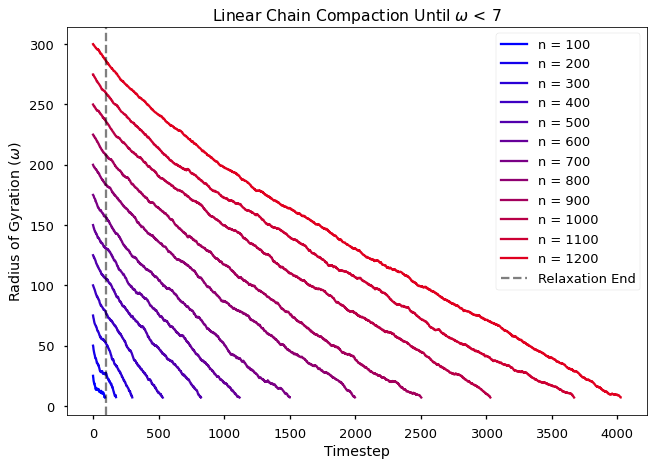

In [ ]:
rog_plot(r"Linear Chain Compaction Until $\omega$ < 7", l_rogs)

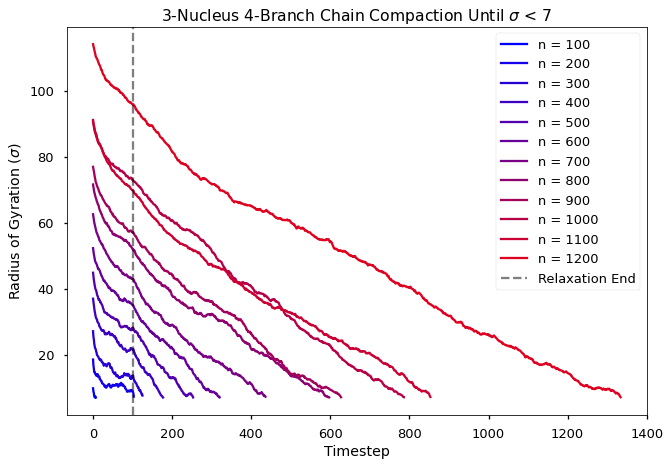

In [ ]:
rog_plot(r"3-Nucleus 4-Branch Chain Compaction Until $\sigma$ < 7", n3b4_rogs)

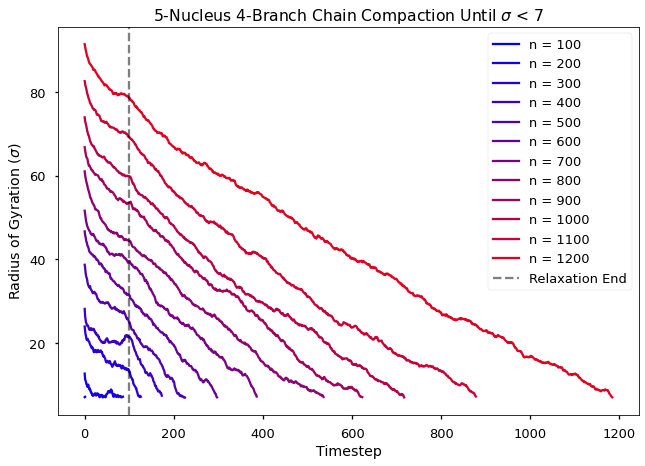

In [ ]:
rog_plot(r"5-Nucleus 4-Branch Chain Compaction Until $\sigma$ < 7", n5b4_rogs)

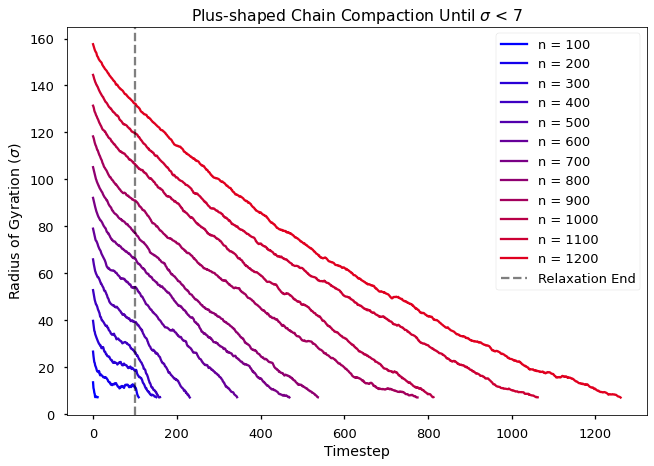

In [ ]:
rog_plot(r"Plus-shaped Chain Compaction Until $\sigma$ < 7", p_rogs)

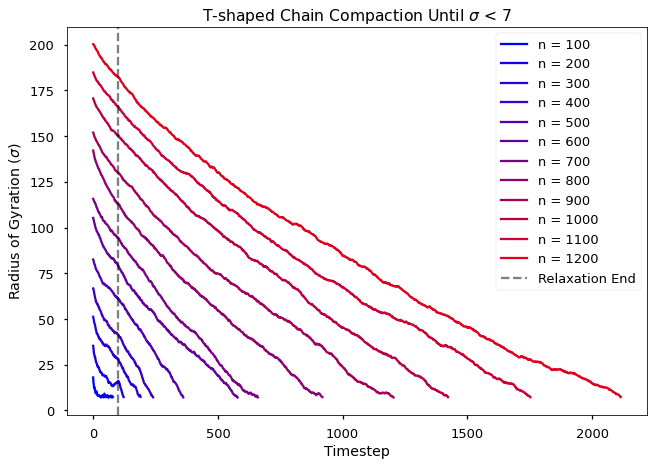

In [ ]:
rog_plot(r"T-shaped Chain Compaction Until $\sigma$ < 7", t_rogs)

In [ ]:
def rog_plot_one_n(n):
    """
    Given the total number of monomers (n) desired, plot the ROG over time
    of each polymer that equals n.

    args
    ------
    n: total number of polymers
    """

    colormap = ["blue", "orange", "green", "red", "purple"]

    index = int((n/100)-1)
    for i, rog in enumerate(rog_list):
        mpl.style.use('seaborn-talk')
        rog_of_choice = rog[index]
        r2 = rog_list2[i][index]
        r3 = rog_list3[i][index]
        plt.plot(r2, alpha = .2, c=colormap[i])
        plt.plot(r3, alpha = .2, c=colormap[i])
        plt.plot(rog_of_choice[rog_of_choice > 7], c=colormap[i], label=rog_labels[i])
        plt.ylabel(r"Radius of Gyration ($\omega$)")
        plt.xlabel("Timestep")
        plt.title(f"Chain Compaction for n = {n} Polymers Until $\omega$ < 7")
        plt.grid(alpha = .7)
    plt.axvline(100, linestyle='dashed', c='black', label="Relaxation End", alpha = .5)
    plt.legend(fontsize = 18)


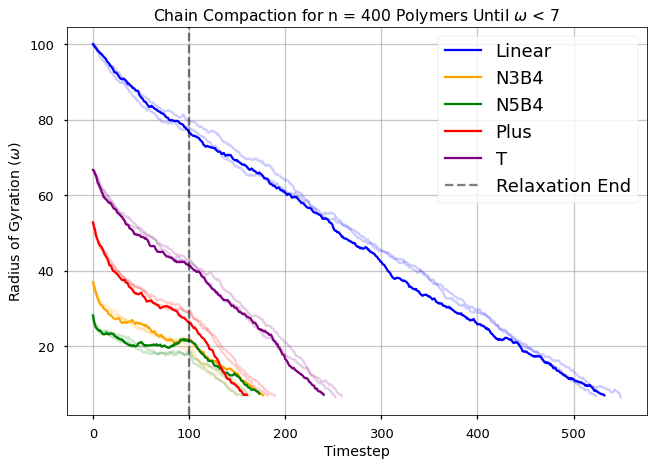

In [ ]:
# Example: For each polymer that has n = 400 total monomers,
# plot ROG over time until < 7. 
rog_plot_one_n(400)

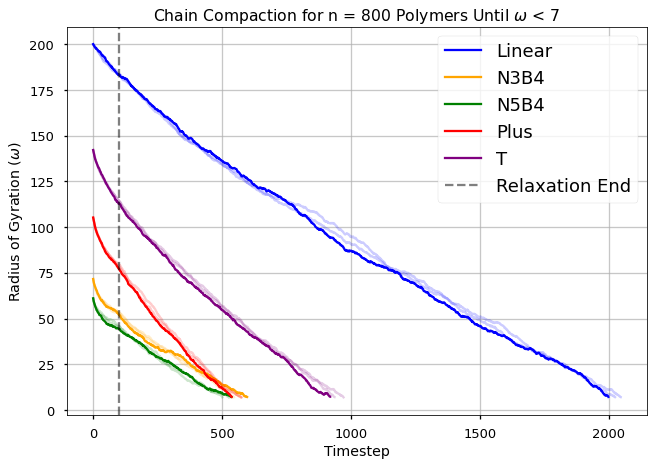

In [ ]:
rog_plot_one_n(800)

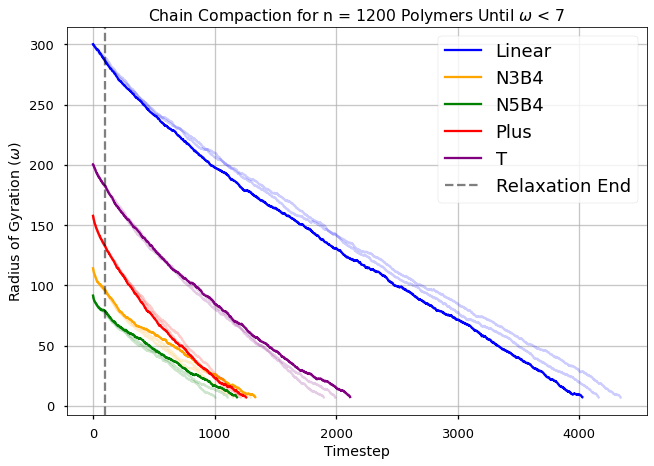

In [ ]:
rog_plot_one_n(1200)

In [ ]:
def rog_plot_one_startingrog(r):

    """
    Given a radius of gyration value of n, find from each polymer the closest
    molecule that starts with that radius of gyration, and plot change over time.
    Stops when ROG < 7. 

    args
    ------
    n: radius of gyration to match a polymer from each type with
    """

    def find_nearest(array, value):  
        array = np.asarray(array) 
        val = array[(np.abs(array - value)).argmin()]
        return np.where(array == val)[0][0]

    colormap = ["blue", "orange", "green", "red", "purple"]

    for i, rog in enumerate(rog_list):
        starting_poss = [v[0] for v in rog[2:]]
        index = find_nearest(starting_poss, r) + 2
        n = (index+1)*100
        mpl.style.use('seaborn-talk')
        rog_of_choice = rog[index]
        r2 = rog_list2[i][index]
        r3 = rog_list3[i][index]
        plt.plot(rog_of_choice[rog_of_choice > 7], c=colormap[i], label=rog_labels[i] + f', n = {n}, $\epsilon$ = {np.round(np.abs(r - rog_of_choice[0]), 1)}')
        plt.plot(r2, alpha = .2, c=colormap[i])
        plt.plot(r3, alpha = .2, c=colormap[i])
        plt.ylabel(r"Radius of Gyration ($\omega$)")
        plt.xlabel("Timestep")
        plt.title(f"Chain Compaction for Starting $\omega$ = {r} Until $\omega$ < 7")
        plt.grid(alpha = .7)
    plt.axvline(100, linestyle='dashed', c='black', label="Relaxation End", alpha = .5)    
    plt.legend(fontsize=18)
    

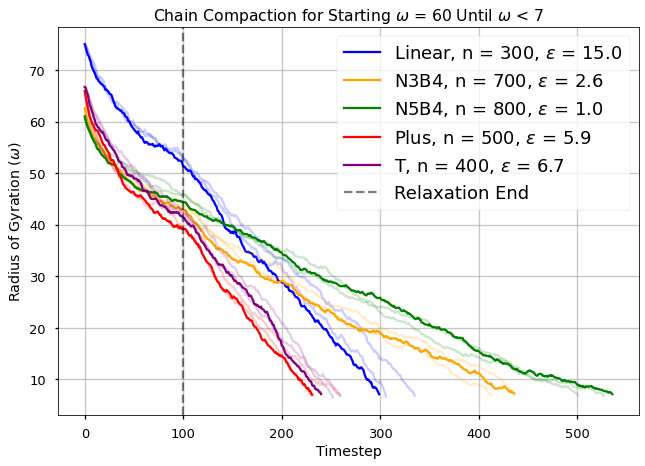

In [ ]:
# Example: find closest polymers from each type that start at 
# a ROG of 6
rog_plot_one_startingrog(60)

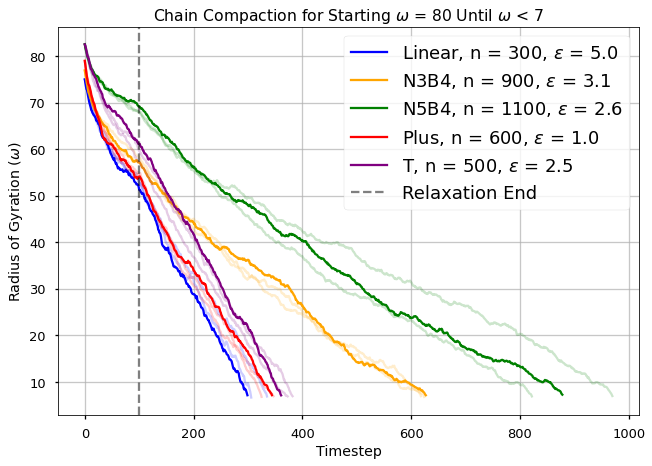

In [ ]:
rog_plot_one_startingrog(80)

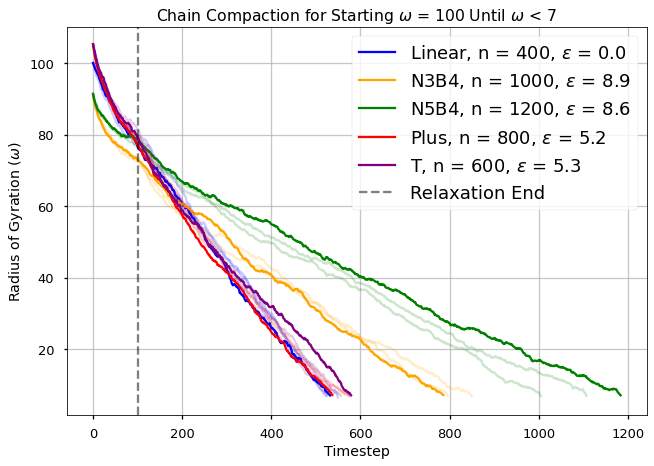

In [ ]:
rog_plot_one_startingrog(100)

In [ ]:
def rog_get_slopes(rogs):
    # Skipping first two sizes due to being extremely short
    slopes = []
    for i, rog in enumerate(rogs[2:]):
        rog_use = rog[rog > 7]
        slope = (rog_use[-1] - rog_use[100])/(len(rog_use)-100)
        slopes.append(slope)
    return slopes


In [ ]:
# Gather data
slopeslist = [rog_get_slopes(rog) for rog in rog_list]
slopeslist2 = [rog_get_slopes(rog) for rog in rog_list2]
slopeslist3 = [rog_get_slopes(rog) for rog in rog_list3]

slopeslistmean = np.mean((np.array(slopeslist), np.array(slopeslist2), np.array(slopeslist3)), axis = 0)
slopeslistSEM = np.std((np.array(slopeslist), np.array(slopeslist2), np.array(slopeslist3)), axis = 0) / np.sqrt(3)

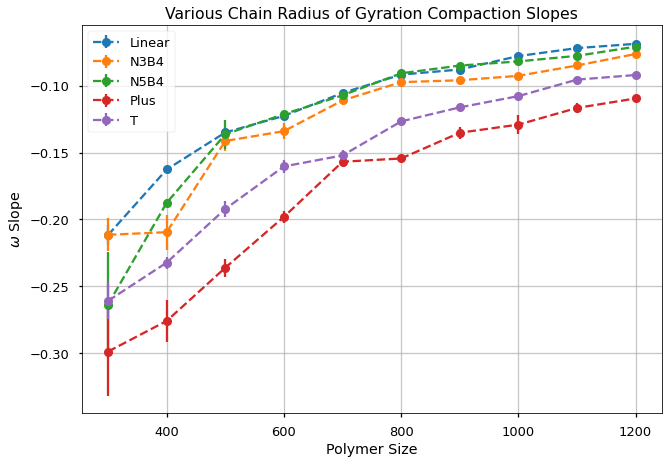

In [ ]:
# 
for i, o in enumerate(slopeslistmean):
    mpl.style.use('seaborn-talk')
    plt.errorbar(np.linspace(300, 1200, 10), o,
                 yerr = slopeslistSEM[i],
                 fmt = 'o--', label=rog_labels[i])
    plt.ylabel(f"$\omega$ Slope")
    plt.xlabel("Polymer Size")
    plt.title(f"Various Chain Radius of Gyration Compaction Slopes")
    plt.grid(alpha = .7)   
plt.legend()

Text(0.5, 0, 'Polymer Size')

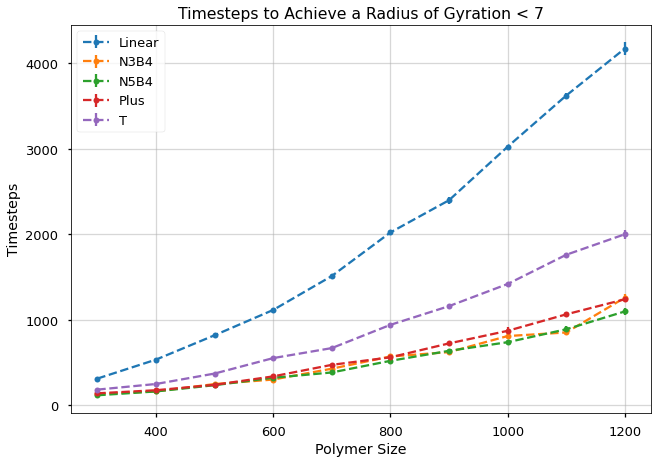

In [ ]:
# 
for i, c in enumerate(cutoffmeans):
    plt.errorbar(np.linspace(300, 1200, 10), c[2:], yerr=cutoffstds[i][2:], 
                 fmt='o--', markersize = 6, mec='black', label = chain_labels[i])

plt.legend()
plt.grid(alpha = .5)
plt.title("Timesteps to Achieve a Radius of Gyration < 7")
plt.ylabel("Timesteps")
plt.xlabel("Polymer Size")

In [ ]:
# Gather initial ROG's for reference 
initial_rogs = []
initial_rogs_std = []

for i, r in enumerate(rog_list):
    v1 = sorted([d[0] for d in r])
    v2 = sorted([d[0] for d in rog_list2[i]])
    v3 = sorted([d[0] for d in rog_list3[i]])

    initial_rogs.append(np.mean((v1, v2, v3), axis=0))
    initial_rogs_std.append(np.std((v1, v2, v3), axis=0)/np.sqrt(3))

# Form ratios of timestep / inital ROG
ratio = []

for i, c in enumerate(cutoffmeans):
    ratio.append((np.array(c[2:])/np.array(initial_rogs[i][2:])))

Text(0.5, 0, 'Polymer Size')

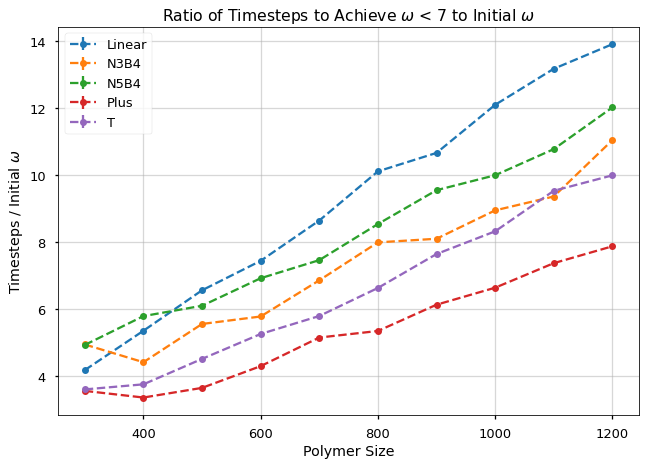

In [ ]:
# Plotting ratio of timestep / initial ROG over all shapes and sizes

for i, c in enumerate(ratio):
    plt.errorbar(np.linspace(300, 1200, 10), 
                 c,
                 yerr = initial_rogs_std[i][2:] ,
                 markersize=7,
                 fmt = 'o--', label = chain_labels[i])

plt.legend()
plt.grid(alpha = .5)
plt.title("Ratio of Timesteps to Achieve $\omega$ < 7 to Initial $\omega$")
plt.ylabel(f"Timesteps / Initial $\omega$")
plt.xlabel("Polymer Size")

### RMSD

#### (RMSD) Extraction, Saving data to files

In [ ]:
# Loop through molecule type
for f in folders:

    # Loop through the number of files
    # for j in range(12):
    for j in np.arange(9, 12):

        # List of trajectory filenames
        traj_filenames = [get_file_list_V2(f + '/trjs')[j], 
                          get_file_list_V2(f + '/trjs2')[j], 
                          get_file_list_V2(f + '/trjs3')[j]]

        # Loop over each trajectory file
        for k, traj_filename in enumerate(traj_filenames):

            # Create a Universe object for the current trajectory
            curr_u = mda.Universe(get_file_list_V2(f + "/dats")[j], traj_filename,
                                  topology_format = "DATA", format = "LAMMPSDUMP")

            rmsdhere = mda.analysis.rms.RMSD(curr_u, curr_u, ref_frame=0).run()
            
            # Save the average trajectory to a file
            np.savetxt(f + f"/rmsds/traj{k+1}_{(j+1)*100}.txt", rmsdhere.rmsd, delimiter='\t')

/usr/local/lib/python3.8/dist-packages/MDAnalysis/analysis/base.py:438: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time
/usr/local/lib/python3.8/dist-packages/MDAnalysis/coordinates/base.py:750: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.time
/usr/local/lib/python3.8/dist-packages/MDAnalysis/analysis/rms.py:718: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


#### (RMSD) Visualization

In [ ]:
def rmsd_same_n(n):

    alphas = [.3, .3]

    for i, f in enumerate(folders):
        data = np.loadtxt(f + f"/rmsds/traj1_{n}.txt", delimiter="\t")[:,2]
        
        # Trim these shapes because simulations keep going with no change
        if n == 1000 and f == "linear":
            data = data[:3000]
        if n == 1000 and f == "plusshaped":
            data = data[:900]

        plt.plot(data, 
                c = colormap[i], 
                label = chain_labels[i])

        for k in range(2):
            plt.plot(np.loadtxt(f + f"/rmsds/traj{k+2}_{n}.txt", delimiter="\t")[:,2], 
                     c = colormap[i], 
                     alpha = alphas[k])
            
    plt.title(f"RMSD for Branched Polymers with Size n = {n}")
    plt.axvline(100, linestyle='dashed', c='black', label="Relaxation End", alpha = .5)
    plt.legend()
    plt.ylabel("RMSD")
    plt.xlabel("Timestep")
    plt.grid(alpha = .5)




In [ ]:
rmsd_same_n(1200)

In [ ]:
def rmsd_slopes():

    x = np.linspace(600, 1000, 5)

    for i, f in enumerate(folders):
        slopeline = []
        slopeerr = []

        for n in x:
            slopes = []

            for k in range(3):

                data = np.loadtxt(f + f"/rmsds/traj{k+1}_{int(n)}.txt", delimiter="\t")[:,2]
                rightlim = 0 + n/2
                rightlim = int(rightlim)

                if n == 1000 and f == "linear":
                    data = data[:3000]
                if n == 1000 and f == "plusshaped":
                    data = data[:900]
            
                slopes.append((data[-1] - data[100]) / (len(data) - 100))

            slopeline.append(np.mean(slopes))
            slopeerr.append(np.std(slopes) / np.sqrt(3))

        plt.errorbar(x,
                     slopeline, 
                     yerr = slopeerr,
                     c = colormap[i],
                     fmt = "o--", 
                     markersize = 5, 
                     label = chain_labels[i],
                     alpha = .7)

            
    plt.title(f"RMSD Compaction Slope for Polymers")
    # plt.axvline(100, linestyle='dashed', c='black', label="Relaxation End", alpha = .5)
    plt.legend()
    plt.ylabel("RMSD Slope")
    plt.xlabel("Polymer Size")
    plt.grid(alpha = .5)
    plt.xticks(x, [int(xs) for xs in x])

In [ ]:
rmsd_slopes()